In [1]:
import sys
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import datetime
from tqdm import tqdm
import GPy
from collections import defaultdict
from pathlib import Path
import seaborn as sns
import scipy.stats as stats
from matplotlib.colors import ListedColormap
import warnings
import time
from itertools import product
from joblib import Parallel, delayed
from operator import itemgetter
import sncosmo
import shutil
import copy

mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True
# mpl.rcParams['figure.dpi'] = 300
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )

In [2]:
path = os.path.dirname(os.getcwd())
os.chdir(path)
from Emulator.Classes.AllData import AllData
from Emulator.Classes.LightCurve import utkarshGrid, LightCurve
from Emulator.Classes.GP import GP
from Emulator.Classes.GP2D import GP2D
from Emulator.Classes.GP5D import GP5D
os.chdir(os.getcwd() + "/Emulator")
os.getcwd()

'/Users/utkarsh/PycharmProjects/KilonovaeLightCurves/Emulator'

In [3]:
curr_wv = np.arange(100, 3600, 10)
set_skip_factor = None
gpSplit = 1

[STATUS] Setting X, Y components for 5D Model.


reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale



Name : GP regression
Objective : 33563699.15336888
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |   (4,)  |   0.01,5.0    |        
  Gaussian_noise.variance  |    1.0  |    0.0,1.0    |        
[STATUS] Optimizing...
Optimization restart 1/3, f = 276781.5691807983
Optimization restart 2/3, f = 240269.72230409912
Optimization restart 3/3, f = 240269.72230421207
[STATUS] 51.58s taken to optimize.
[STATUS] Predicting X and Y with trained emulator.
[STATUS] 0.01s taken to predict single item.
[STATUS] 0.01s taken to save data.
Inside 3x: 35000, Total: 35000


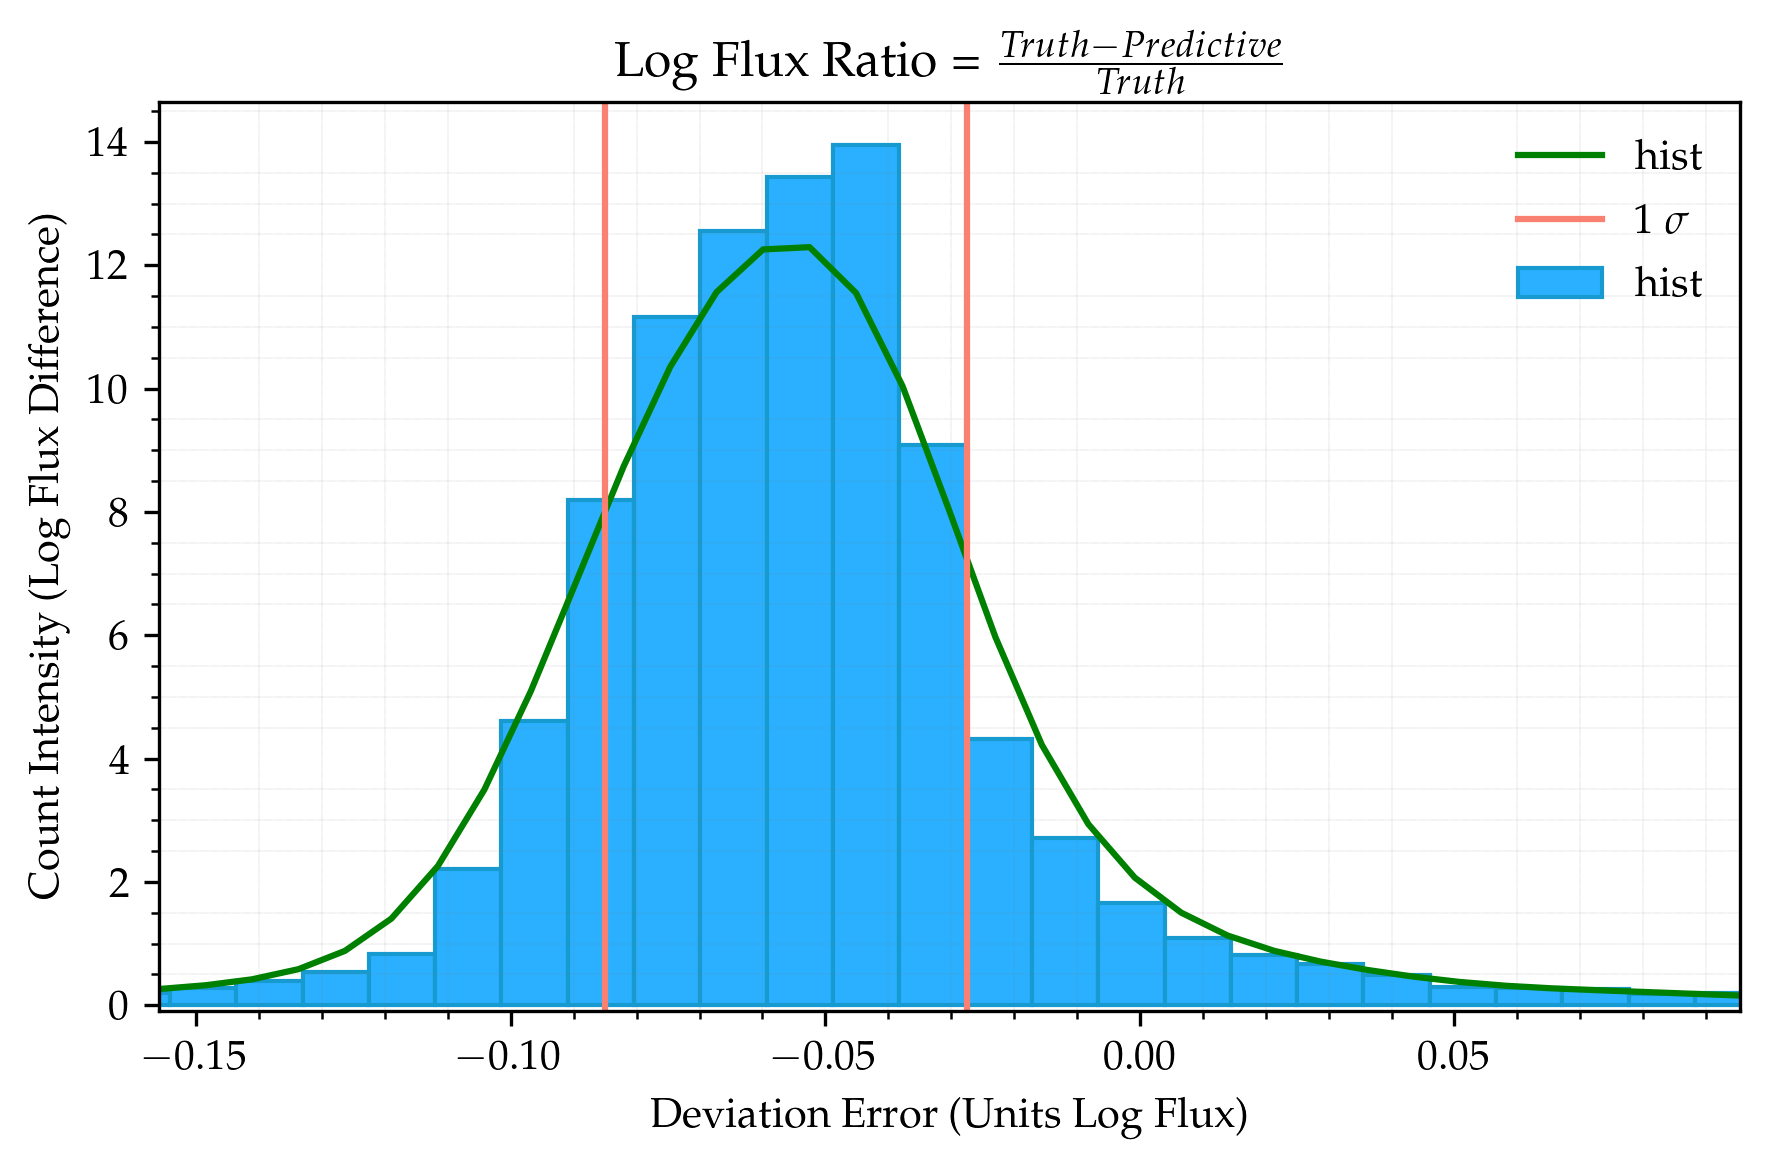

In [4]:
mejdyn = 0.005 #0.01
mejwind =  0.05 #0.13
phi = 45 #90
iobs = 6 #1
mejdyn2 = copy.deepcopy(mejdyn)
mejwind2 = copy.deepcopy(mejwind)
phi2 = copy.deepcopy(phi)
iobs2 = copy.deepcopy(iobs)

gp = GP5D("Classes/reference.csv")
gp.delete_folder_files("data/pcaComponents")
gp.delete_folder_files("data/pcaComponentsTrained")
gp.delete_folder_files("data/pcaComponentsTrainedError")
gp.delete_folder_files("data/pcaTrained")
gp.delete_folder_files("data/pcaTrainedUpper")
gp.delete_folder_files("data/pcaTrainedLower")
gp.split = gpSplit
gp.emulator = "start"
gp.cross_validation = (mejdyn, mejwind, phi, iobs)
gp.set_wv_range(curr_wv)
gp.n_comp = 25
time_shape = None
# gp.save_training_data(time_trauncation = time_shape) # Which wv do you want to extract.  
gp.save_pca_components(skip_factor = set_skip_factor)
gp.setXY_cross_validation(mejdyn, mejwind, phi, iobs)
fitting_kernel = GPy.kern.RBF(input_dim=4, variance = 1, lengthscale=1, ARD = True)
decay_kernel = GPy.kern.Linear(input_dim=4, ARD = False)
gp.kernel = fitting_kernel #* decay_kernel
gp.model = GPy.models.GPRegression(gp.X,gp.Y,gp.kernel)
gp.model.Gaussian_noise.variance.constrain_bounded(0,1.)     
gp.model.rbf.lengthscale.constrain_bounded(0.01,5.)       
print(gp.model)
t0 = time.time()
print(f"[STATUS] Optimizing...")
gp.model.optimize_restarts(parallel = True, robust = True, num_restarts = 3)
print(f"[STATUS] {round(time.time() - t0, 2)}s taken to optimize.")
# gp.model.optimize(messages = True)
# display(gp.model.rbf.lengthscale)
# display(gp.model)
# display(gp.model.mul.rbf.lengthscale)
t1 = time.time()
gp.model_predict_cross_validation(include_like = True) # Save cross validation
print(f"[STATUS] {round(time.time() - t1, 2)}s taken to predict single item.")
# gp.model_predict(include_like = True)
# print(f"[STATUS] {round(time.time() - t1, 2)}s taken to predict every item.")
t2 = time.time()
gp.save_trained_data()
print(f"[STATUS] {round(time.time() - t2, 2)}s taken to save data.")
gp.ComputeDifferenceFlux()
gp.plot_difference_histogram(binning = 350)
plt.show()

In [5]:
# display(gp.model.linear.variances)

AttributeError: 'GPRegression' object has no attribute 'mul'

=== Flux Estimation === 
mejdyn: 0.005
mejwind: 0.05        
phi: 45
viewing_angle: 6
wavelength: 950nm        
time: 2.0 days

LOG FLUX: -2.57607


100%|██████████| 196/196 [00:00<00:00, 222.76it/s]


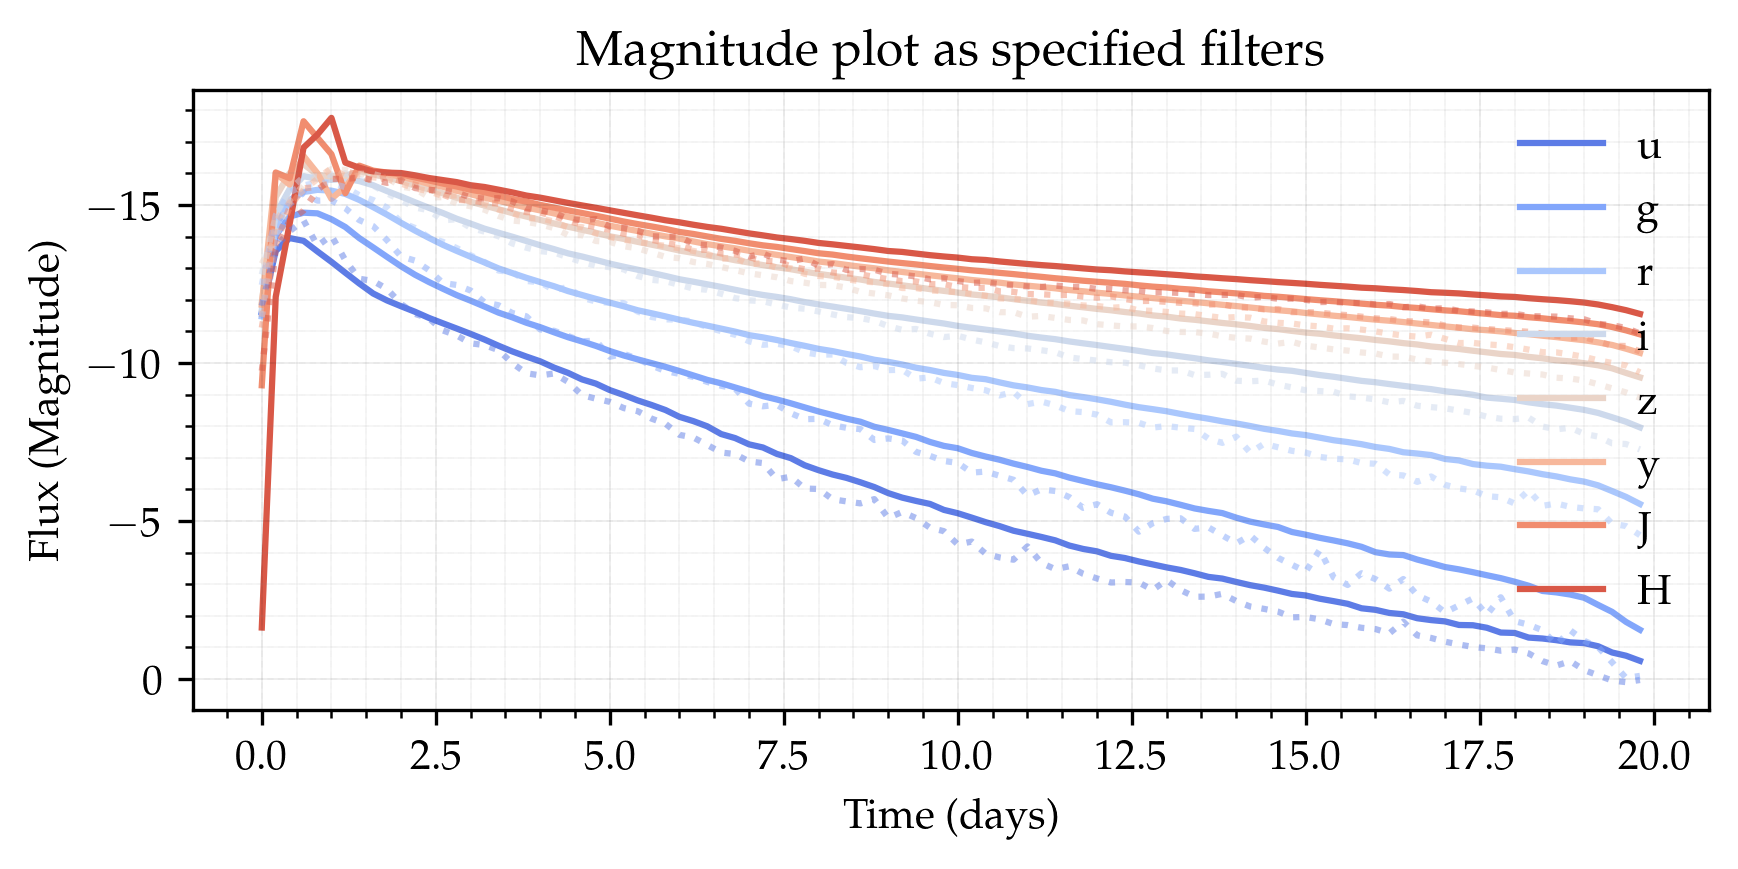

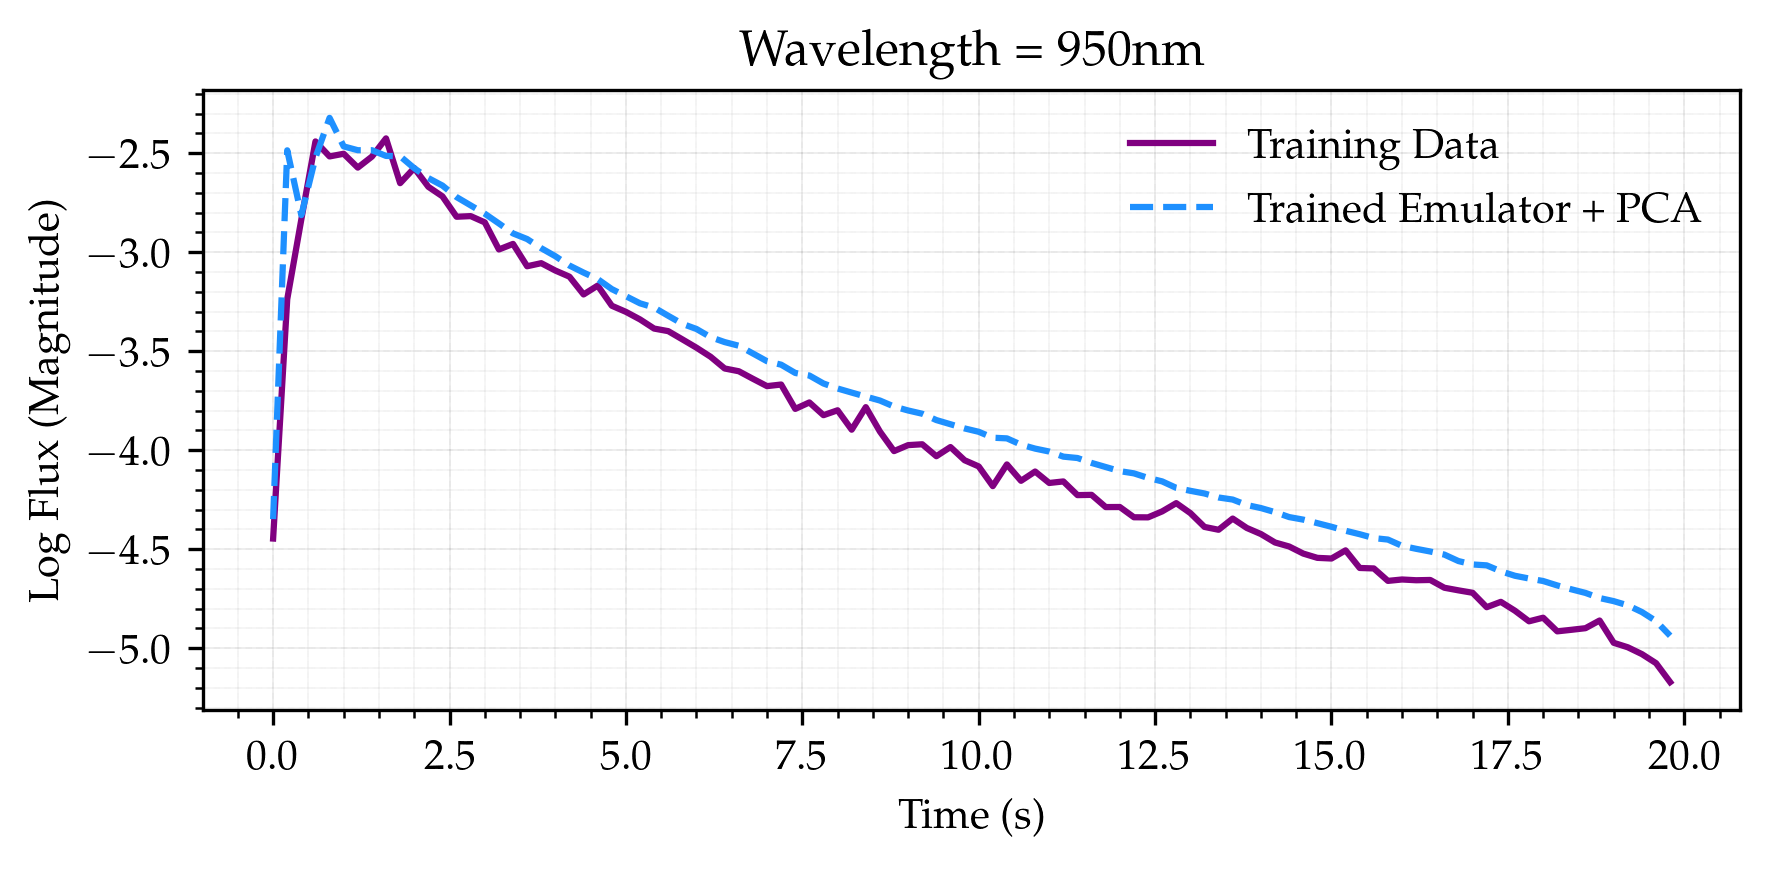

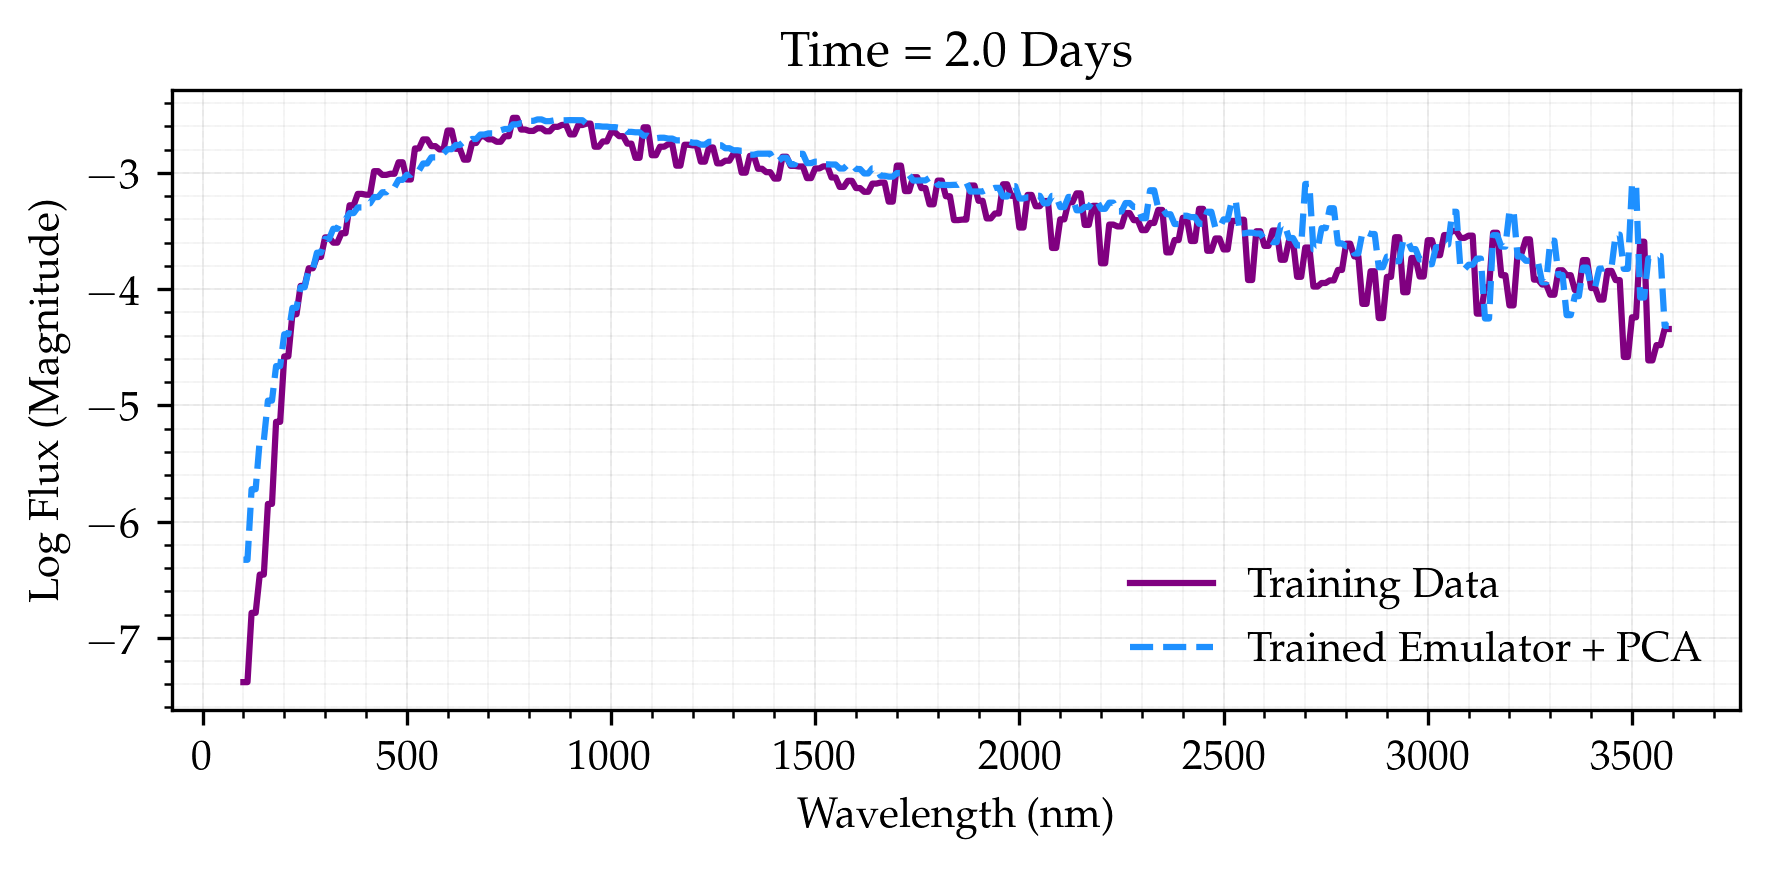

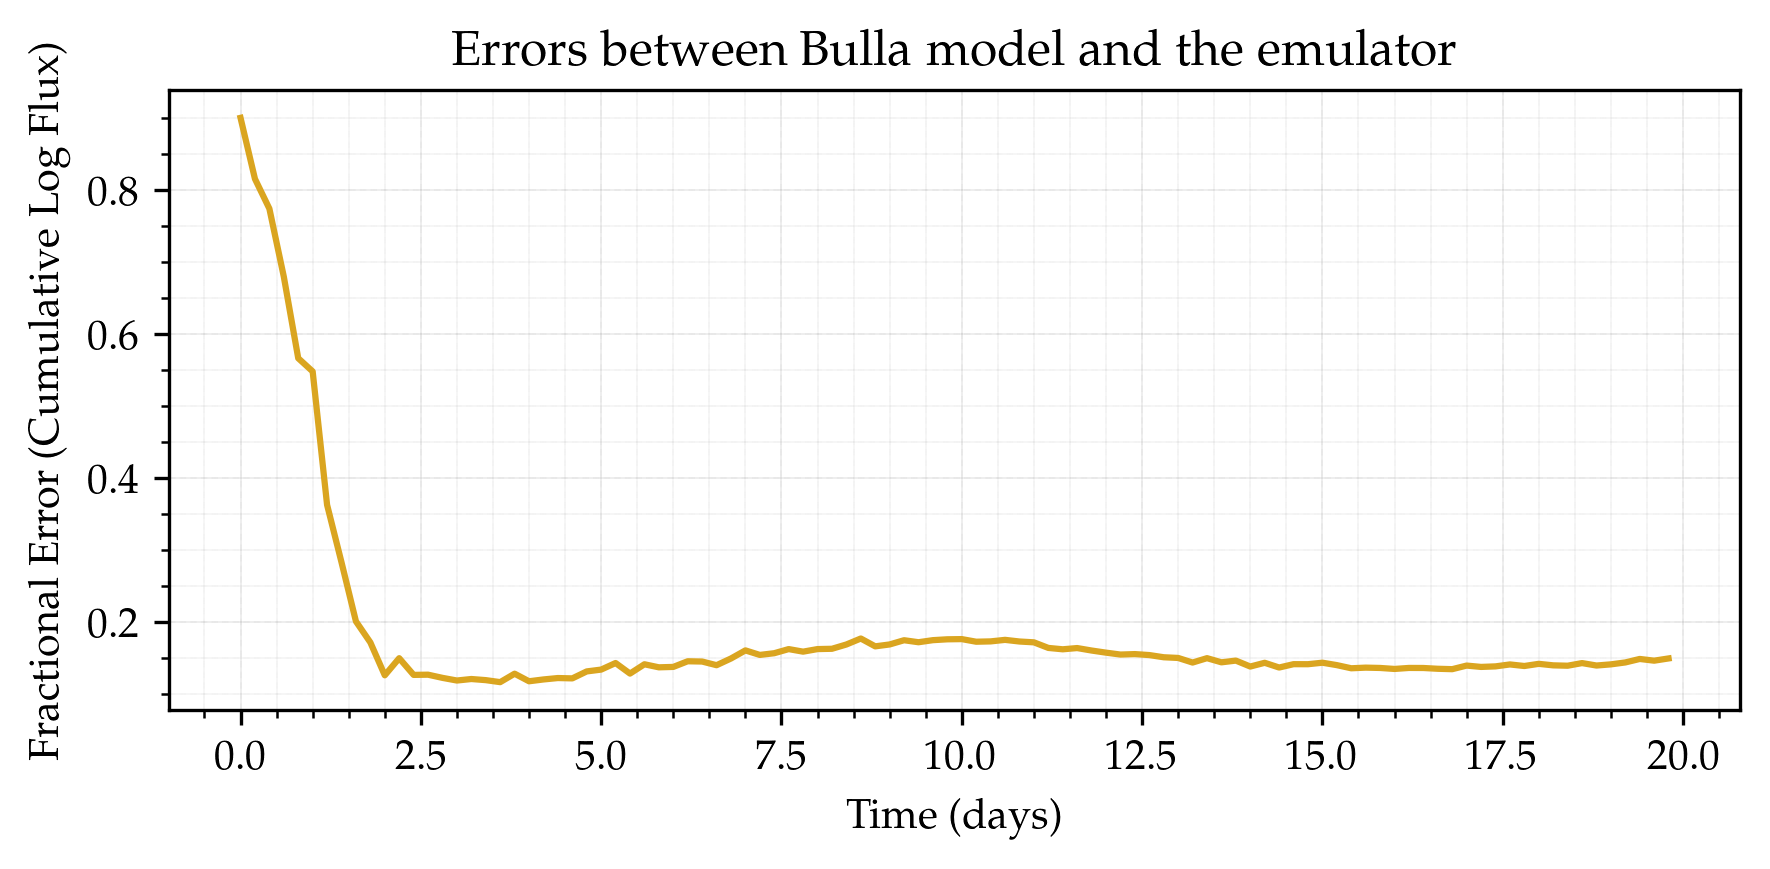

In [6]:
gp.get_flux(mejdyn = mejdyn, mejwind =  mejwind, phi = phi, iobs = iobs, time_desired = 2, wv_desired = 950)
gp.plot_filters(mejdyn = mejdyn, mejwind =  mejwind, phi = phi, iobs = iobs)
gp.overplot_time(mejdyn = mejdyn, mejwind =  mejwind, phi = phi, iobs = iobs, wv_desired = 950)
gp.overplot_wavelength(mejdyn = mejdyn, mejwind =  mejwind, phi = phi, iobs = iobs, time_desired = 2)
gp.plot_emulator_errors()
plt.show()

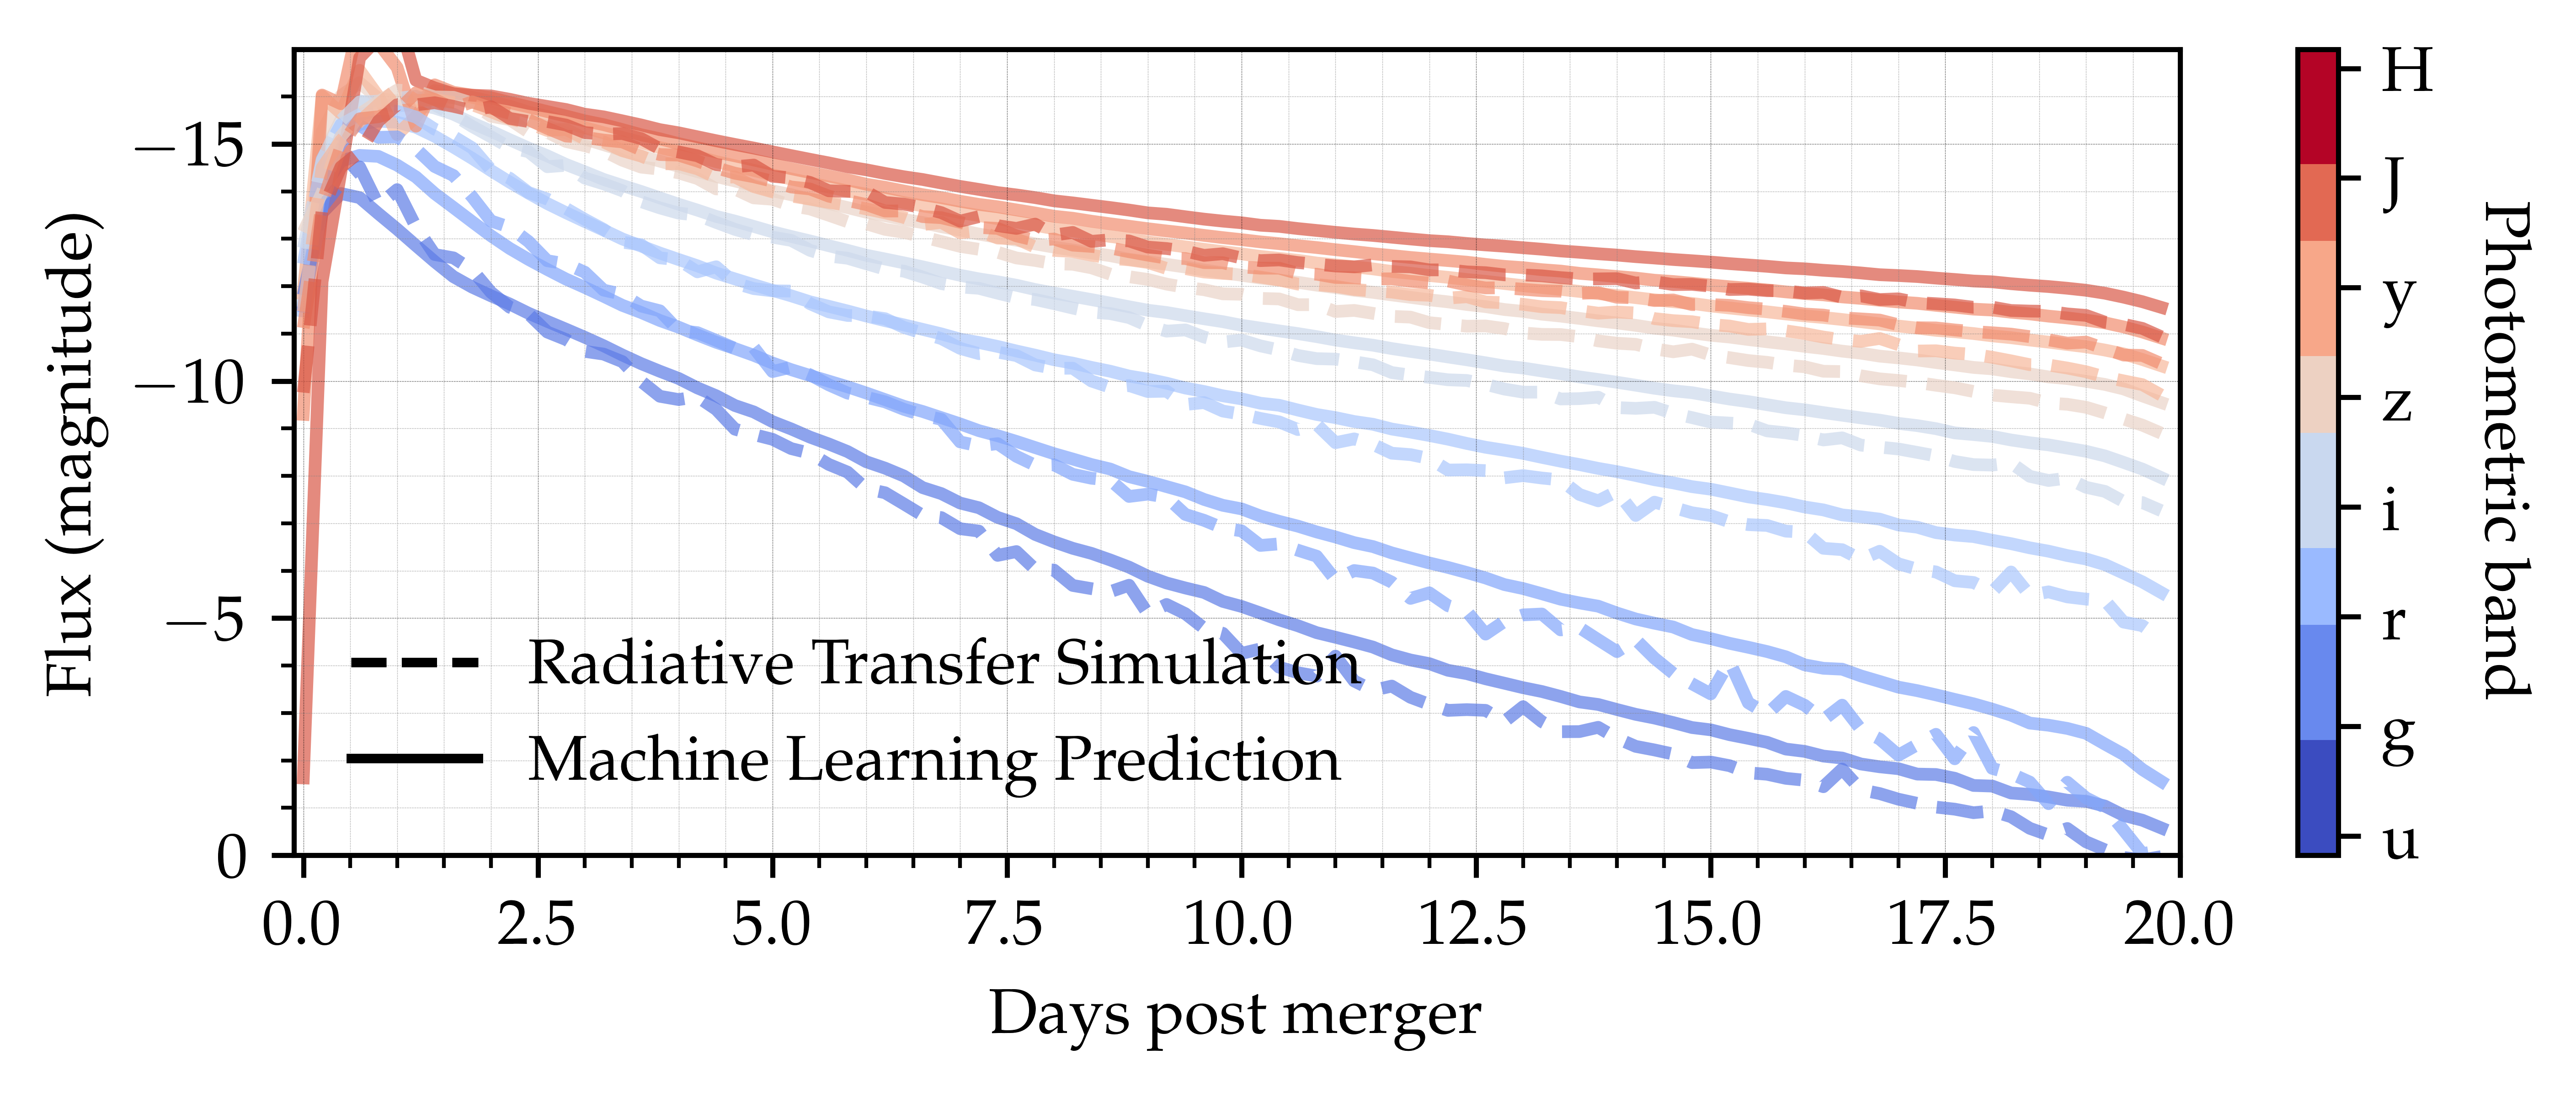

In [7]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
self = gp
col_name="coolwarm_r"
# col_name="plasma"
t = self._t_helper()
untrained = np.load(f"data/pca/mejdyn{mejdyn}_mejwind{mejwind}_phi{phi}_iobs{iobs}.npy")
untrained = self._untrained_helper(untrained)
trained = np.load(f"data/pcaTrained/mejdyn{mejdyn}_mejwind{mejwind}_phi{phi}_iobs{iobs}.npy")
filters = ["sdss::u", "sdss::g", "sdss::r", "sdss::i", "sdss::z",
           "swope2::y", "swope2::J", "swope2::H"]

colors = sns.color_palette(col_name, len(filters))[::-1]

plt.figure(dpi=1000, figsize=(6, 2.5))
for i in range(len(filters)):
    source = sncosmo.TimeSeriesSource(t, self.wv_range * 10, 10 ** trained)
    source2 = sncosmo.TimeSeriesSource(t, self.wv_range * 10, 10 ** untrained)
    m = source.bandmag(filters[i], "ab", t)
    m2 = source2.bandmag(filters[i], "ab", t)
    plt.plot(t, m, color=colors[i], zorder=1, alpha = 0.7, linewidth = 2)
    plt.plot(t, m2, linestyle="dashed", alpha=0.7, color=colors[i], zorder=2, linewidth = 2)

plt.plot(t, np.ones(t.shape), linestyle = "dashed", color = "black", label = "Radiative Transfer Simulation", alpha = 1)
plt.plot(t, np.ones(t.shape), linestyle = "solid", color = "black", label = "Machine Learning Prediction", alpha = 1)

cmap = plt.get_cmap(col_name,len(filters))
norm = mpl.colors.Normalize(vmin=0,vmax=2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(0,2,len(filters)), boundaries=np.arange(-0.05,2.1,.1))
cbar.ax.set_yticklabels([item[-1] for item in filters][::-1])
cbar.set_label('Photometric band', rotation=270, labelpad=15)
cbar.ax.invert_yaxis()
# cbar.set_label('Photometric Band', labelpad=-40, y=1.05, rotation=0)


# plt.gca().set_facecolor('black')
# l = plt.legend(prop ={'weight':'bold'}, loc = "upper right")
# for text in l.get_texts():
#     text.set_color("white")

# split_arrow = 5
# plt.vlines(x = split_arrow, ymin = -2, ymax = -3, color = "white", alpha = 0.9)
# plt.annotate(text = "Emulator A", xy  = (1, -1.25), color = "white", fontsize = 9)
# plt.annotate(text = "Emulator B", xy  = (11, -1.25), color = "white", fontsize = 9)
# plt.annotate(text='', xy=(split_arrow,-2.5), xytext=(0,-2.5), arrowprops=dict(arrowstyle='<->', color='white'), color = "white")
# plt.annotate(text='', xy=(20,-2.5), xytext=(split_arrow,-2.5), arrowprops=dict(arrowstyle='<->', color='white'), color = "white")

utkarshGrid()
plt.legend()
plt.ylim(-17, 0)
plt.xlim(-0.1, 20)
plt.gca().invert_yaxis()
plt.xlabel("Days post merger")
plt.ylabel("Flux (magnitude)")
# plt.title(f"Magnitude plot as specified filters", fontsize = 16)
plt.savefig("flux.pdf")

 41%|████▏     | 81/196 [00:00<00:00, 187.16it/s]

Looped


100%|██████████| 196/196 [00:00<00:00, 204.89it/s]


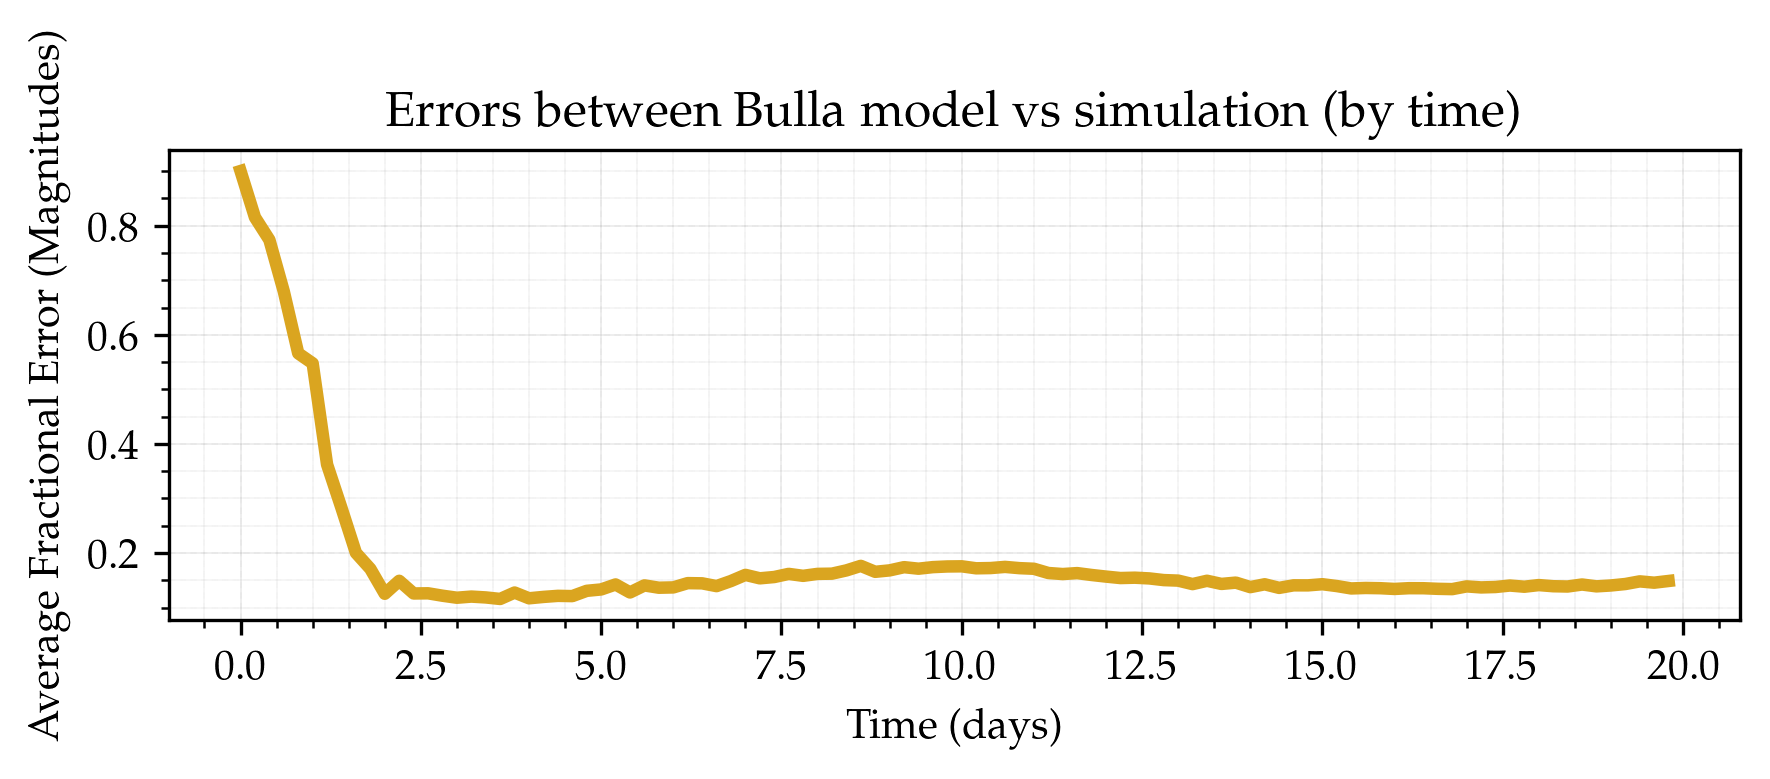

In [8]:
self = gp
t = self._t_helper()
diff = np.zeros(t.shape)
counter = 0
eps = 1e-18

for index, row, in tqdm(self.reference.iterrows(), total=196):
    for viewing_angle in self.iobs_range:
        mejdyn = row.mejdyn
        mejwind = row.mejwind
        phi = row.phi
        iobs = viewing_angle

        try:
            untrained = np.load(f"data/pca/mejdyn{mejdyn}_mejwind{mejwind}_phi{phi}_iobs{iobs}.npy")
            trained = np.load(f"data/pcaTrained/mejdyn{mejdyn}_mejwind{mejwind}_phi{phi}_iobs{iobs}.npy")
            untrained = self._untrained_helper(untrained)
        except:
            continue

        # diff = diff + np.sum(np.abs((trained - untrained) / untrained), axis = 1)/self.num_wv
        diff = diff + 2.5 * np.sum(np.abs((trained - untrained)/(untrained)), axis=1) / self.num_wv
        counter += 1
        print("Looped")

diff = diff / counter  # Divide each wavelength and each training point and viewing angle

plt.figure(dpi=300, figsize=(6, 2.5))
plt.plot(t, diff, color="goldenrod", linewidth = 3)
utkarshGrid()
plt.title("Errors between Bulla model vs simulation (by time)")
plt.ylabel("Average Fractional Error (Magnitudes)")
plt.xlabel("Time (days)")
plt.show()

Inside 3x: 34956, Total: 35000


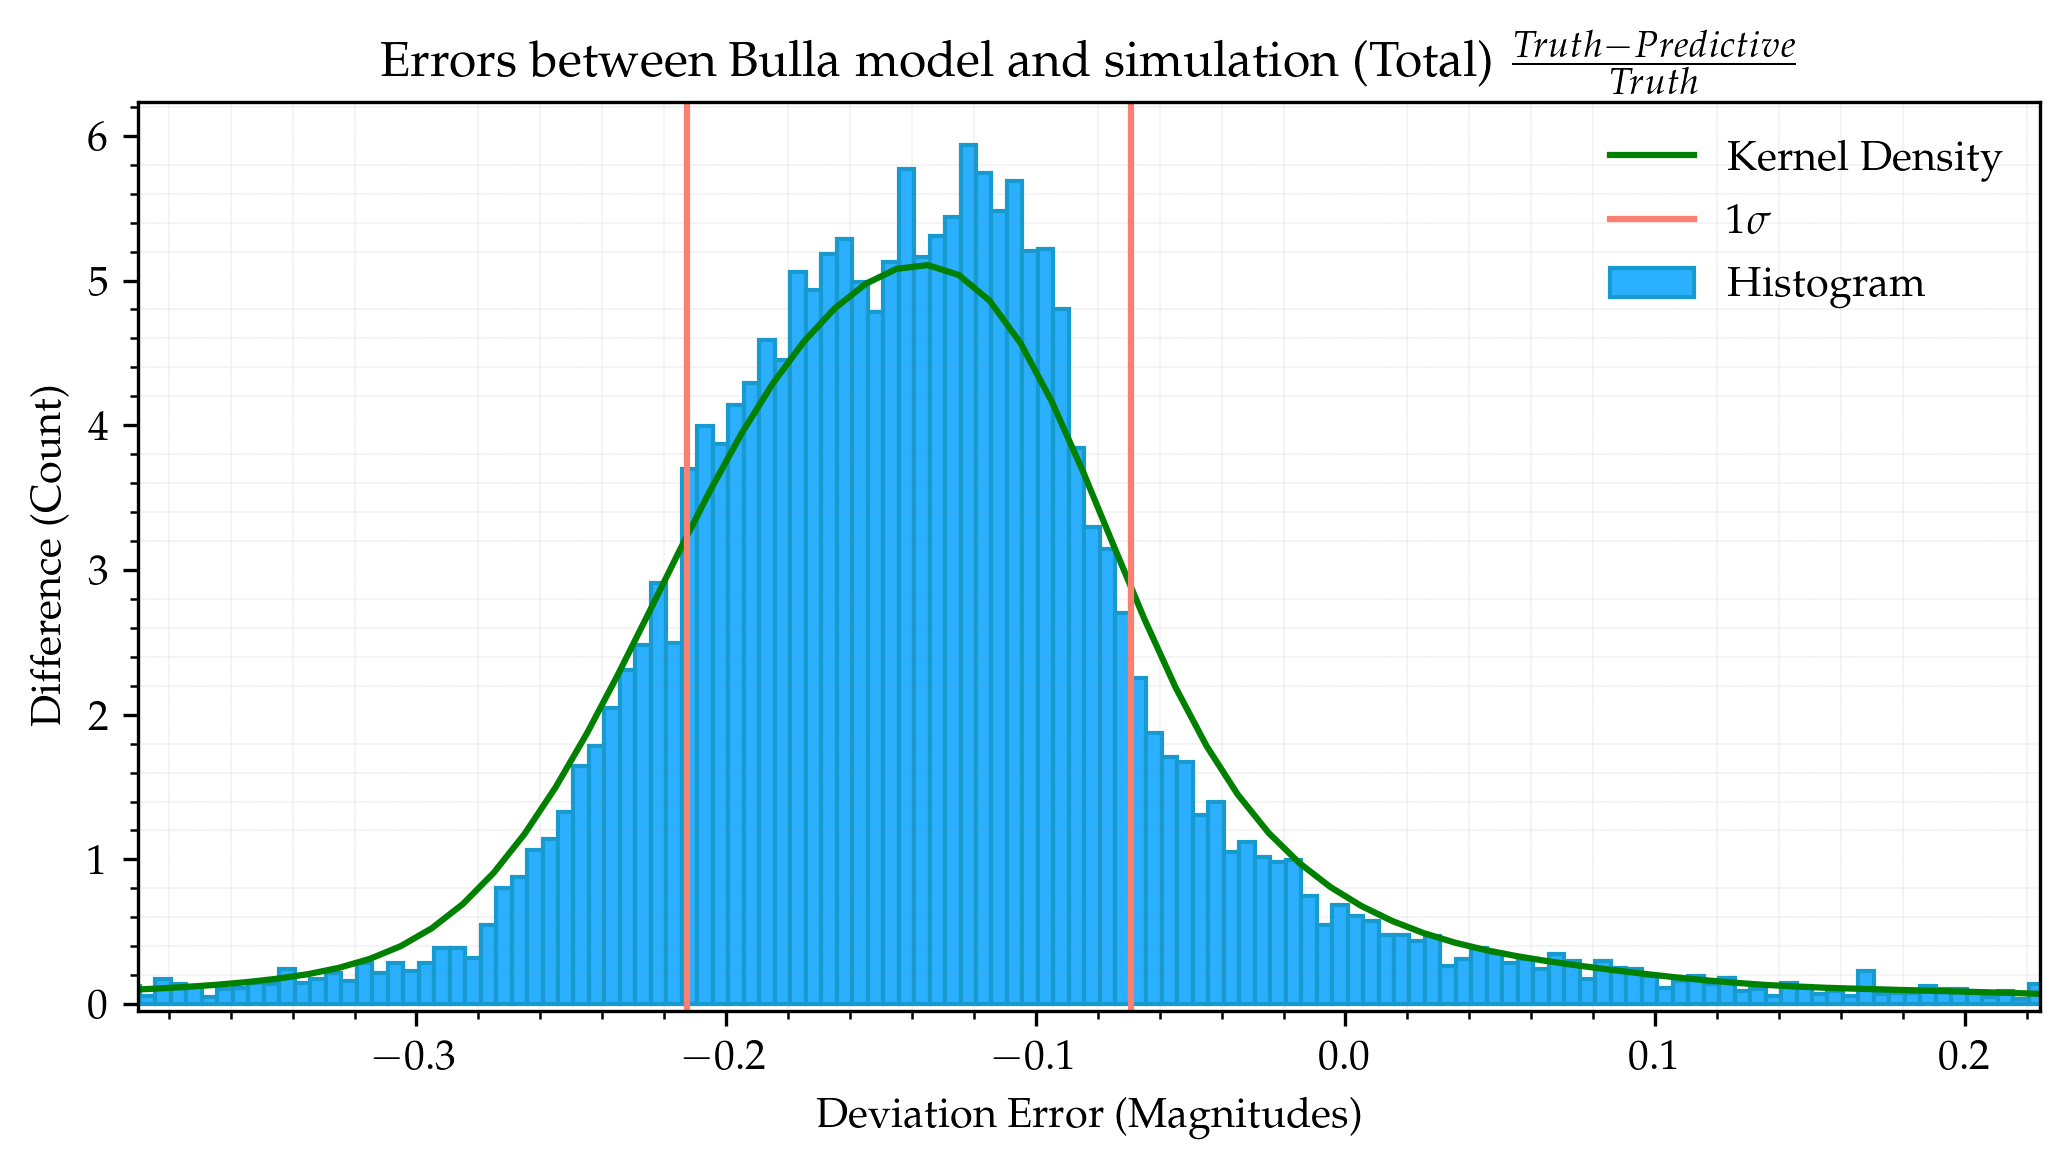

In [9]:
edge=2.5
mu=0
sigma=1
binning=1000
fig, ax = plt.subplots(dpi=300, figsize=(7, 4))
utkarshGrid()

hist_arr = self.difference.flatten() * 2.5
hist_arr = hist_arr[np.isfinite(hist_arr)]
hist_arr = hist_arr[hist_arr < 3]
hist_arr = hist_arr[hist_arr > -3]
print(f"Inside 3x: {len(hist_arr)}, Total: {len(self.difference.flatten())}")

df = pd.DataFrame(hist_arr, columns=["hist"])

# y, binEdges = np.histogram(hist_arr, bins=binning, density=True, normed=True)
# bincenters = 0.5 * (binEdges[1:] + binEdges[:-1])
# menStd = np.sqrt(y)
# mx = y + np.sqrt(y)
# mn = y - np.sqrt(y)
# plt.fill_between(bincenters, mn, mx, alpha=0.2, zorder=3, color="limegreen")
# percentiles_lower = np.percentile(hist_arr, 2.27)
# percentiles_upper = np.percentile(hist_arr, 97.73)
percentiles_lower = np.percentile(hist_arr, 16)
percentiles_upper = np.percentile(hist_arr, 84)

df.plot.hist(density=True, bins=binning, ax=ax, label="Count",
             facecolor='#2ab0ff', edgecolor='#169acf', zorder=1)

df.plot.kde(ax=ax, label="LOOCV Distribution", alpha=1, zorder=2, color="green")
plt.axvline(x=percentiles_lower, color="salmon", label=r"1 $\sigma$")
plt.ylabel("Difference (Count)")
plt.xlabel(r"Deviation Error (Magnitudes)")

# if self.empirical:
#     ax.legend(["Density Distribution ", "Count", r"1 $\sigma$ Confidence"])
#     ax.set_title(r"Flux Ratio = $\frac{{Truth - Predictive}}{Truth}$")
#
#
# else:
#     ax.set_title(r"Flux Ratio = $\frac{{Truth - Predictive}}{\sigma}$")
ax.legend(["Kernel Density ", "1$\sigma$", "Histogram"])
ax.set_title(r"Errors between Bulla model and simulation (Total) $\frac{{Truth - Predictive}}{Truth}$")
plt.axvline(x=percentiles_upper, color="salmon")
ax.set_ylim(bottom=-0.05)
ax.set_xlim(np.percentile(hist_arr, 2.5), np.percentile(hist_arr, 97.5))
# ax.set_xlim(-0.15, 0.15)
# ax.set_xlim(-0.4, 0.4)
plt.show()

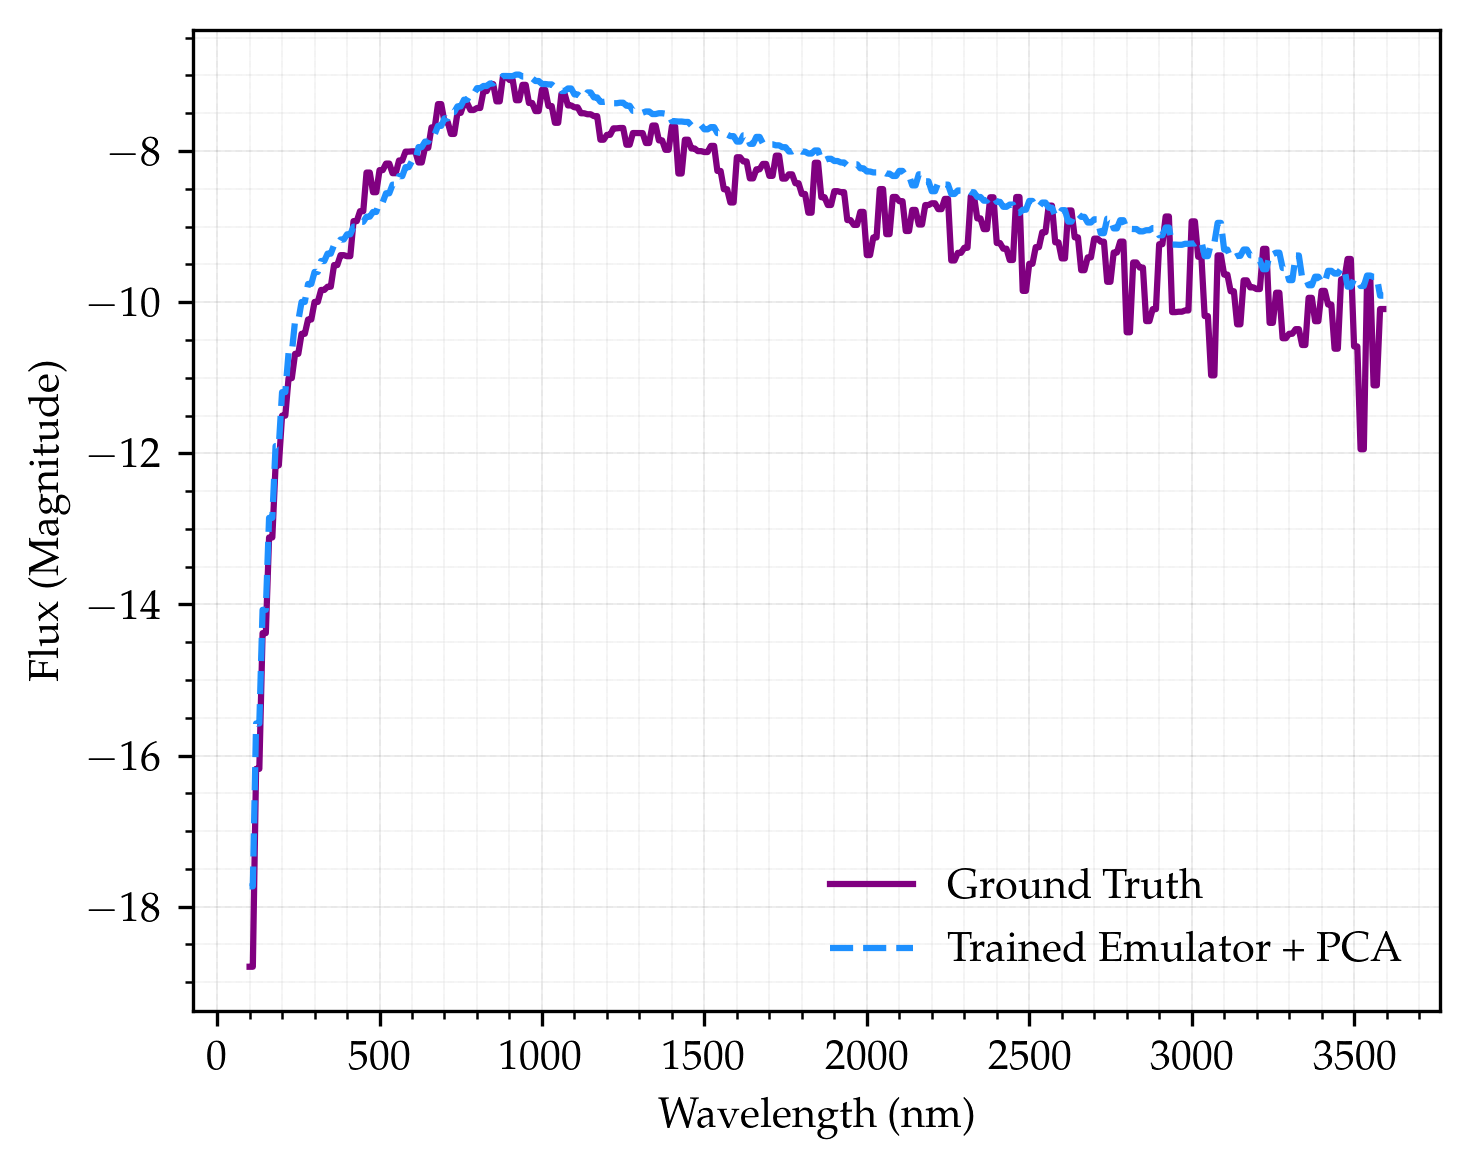

In [10]:
mejdyn = mejdyn2
mejwind =  mejwind2
phi = phi2
iobs = iobs2
time_desired = 3
t = self._t_helper()
time_index = (np.abs(t - time_desired)).argmin()  # Plot arbitary wavelength.
trained = np.load(f"data/pcaTrained/mejdyn{mejdyn}_mejwind{mejwind}_phi{phi}_iobs{iobs}.npy") * 2.5

# if errors is False:
#     trainedUpper = np.load(f"data/pcaTrainedUpper/mejdyn{mejdyn}_mejwind{mejwind}_phi{phi}_iobs{iobs}.npy")
#     trainedLower = np.load(f"data/pcaTrainedLower/mejdyn{mejdyn}_mejwind{mejwind}_phi{phi}_iobs{iobs}.npy")
untrained = np.load(f"data/pca/mejdyn{mejdyn}_mejwind{mejwind}_phi{phi}_iobs{iobs}.npy")
untrained = self._untrained_helper(untrained) * 2.5

plt.figure(dpi=300, figsize=(5, 4))
# plt.title(f"Time = {round(t[time_index], 3)} Days")
plt.plot(self.wv_range, untrained[time_index, :], label="Ground Truth", color="purple")
plt.plot(self.wv_range, trained[time_index, :], label="Trained Emulator + PCA",
         linestyle="dashed", color="dodgerblue")
# plt.plot(self.wv_range, trainedUpper[time_index, :], alpha=0.3, color="lightblue",
#          label=r"1$\sigma$ Error (UNFINISHED)")
# plt.plot(self.wv_range, trainedLower[time_index, :], alpha=0.3, color="lightblue")
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Flux (Magnitude)")
utkarshGrid()

In [11]:
# gp = GP5D("Classes/reference.csv")
# gp.split = gpSplit
# gp.emulator = "end"
# gp.cross_validation = (mejdyn, mejwind, phi, iobs)
# gp.set_wv_range(curr_wv)
# gp.n_comp = 25
# time_shape = None
# # gp.save_training_data(time_trauncation = time_shape) # Which wv do you want to extract.  
# gp.save_pca_components(skip_factor = set_skip_factor)
# gp.setXY_cross_validation(mejdyn, mejwind, phi, iobs)
# fitting_kernel = GPy.kern.RBF(input_dim=4, variance = 10, lengthscale=10, ARD = True)
# decay_kernel = GPy.kern.Linear(input_dim=4, ARD = True)
# gp.kernel = fitting_kernel * decay_kernel
# gp.model = GPy.models.GPRegression(gp.X,gp.Y,gp.kernel)
# t0 = time.time()
# print(f"[STATUS] Optimizing...")
# gp.model.optimize_restarts(parallel = True, robust = True, num_restarts = 3)
# print(f"[STATUS] {round(time.time() - t0, 2)}s taken to optimize.")
# # gp.model.optimize(messages = True)
# # display(gp.model.rbf.lengthscale)
# display(gp.model.mul.rbf.lengthscale)
# t1 = time.time()
# gp.model_predict_cross_validation(include_like = True) # Save cross validation
# print(f"[STATUS] {round(time.time() - t1, 3)}s taken to predict single item.")
# gp.model_predict(include_like = True)
# print(f"[STATUS] {round(time.time() - t1, 2)}s taken to predict every item.")
# t2 = time.time()
# gp.save_trained_data()
# print(f"[STATUS] {round(time.time() - t2, 2)}s taken to save data.")
# gp.ComputeDifferenceFlux()
# gp.plot_difference_histogram(binning = 350)
# plt.show()

In [ ]:
# gp.get_flux(mejdyn = mejdyn, mejwind =  mejwind, phi = phi, iobs = iobs, time_desired = 2, wv_desired = 950)
# gp.plot_filters(mejdyn = mejdyn, mejwind =  mejwind, phi = phi, iobs = iobs)
# gp.overplot_time(mejdyn = mejdyn, mejwind =  mejwind, phi = phi, iobs = iobs, wv_desired = 950)
# gp.overplot_wavelength(mejdyn = mejdyn, mejwind =  mejwind, phi = phi, iobs = iobs, time_desired = 2)
# gp.plot_emulator_errors()
# plt.show()